## Problem Definition 

Life expectancy differs significantly across countries, reflecting a complex interplay of various socioeconomic, environmental, and healthcare factors that influence how long people live. Understanding these factors and their impact on life expectancy is crucial for developing policies and interventions aimed at improving global health outcomes.

## Objective

This project seeks to identify and analyze the key determinants of life expectancy, exploring how variables such as access to healthcare, education, and environmental conditions contribute to disparities in longevity across different regions.

## Research questions

1. **Which region & country currently has the lowest average life expectancy, and what factors contribute to this?**  

2. **Which country has the highest life expectancy, and what are the underlying reasons for its longevity?**  

3. **Has life expectancy been increasing over time, and is this trend consistent across all countries?**  
 
4. **What are the key factors influencing life expectancy across different countries?**  
  

In [23]:
#import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split



In [24]:
data = pd.read_csv('life_expectancy.csv')
data.head()

,Country Name,Country Code,Region,IncomeGroup,Year,Life Expectancy World Bank,Prevelance of Undernourishment,CO2,Health Expenditure %,Education Expenditure %,Unemployment,Corruption,Sanitation,Injuries,Communicable,NonCommunicable
0,Afghanistan,AFG,South Asia,Low income,2001,56.308,47.8,730.0,NaN,NaN,10.809000,NaN,NaN,2179727.10,9689193.70,5795426.38
1,Angola,AGO,Sub-Saharan Africa,Lower middle income,2001,47.059,67.5,15960.0,4.483516,NaN,4.004000,NaN,NaN,1392080.71,11190210.53,2663516.34
2,Albania,ALB,Europe & Central Asia,Upper middle income,2001,74.288,4.9,3230.0,7.139524,3.4587,18.575001,NaN,40.520895,117081.67,140894.78,532324.75
3,Andorra,AND,Europe & Central Asia,High income,2001,NaN,NaN,520.0,5.865939,NaN,NaN,NaN,21.788660,1697.99,695.56,13636.64
4,United Arab Emirates,ARE,Middle East & North Africa,High income,2001,74.544,2.8,97200.0,2.484370,NaN,2.493000,NaN,NaN,144678.14,65271.91,481740.70


### Data cleaning 

In [25]:
#rename columns 
data = data.rename(columns={'Life Expectancy World Bank':'Life_expectancy', 'Prevelance of Undernourishment': 'Undernourishment'})
#check data shape 
print(data.shape)

(3306, 16)


In [26]:
#check for missing values 
missing_values = data.isnull().sum()
missing_values

Country Name                  0
Country Code                  0
Region                        0
IncomeGroup                   0
Year                          0
Life_expectancy             188
Undernourishment            684
CO2                         152
Health Expenditure %        180
Education Expenditure %    1090
Unemployment                304
Corruption                 2331
Sanitation                 1247
Injuries                      0
Communicable                  0
NonCommunicable               0
dtype: int64

### Handle missing values 

For life expectancy, we will fill the missing values with the mean life expectancy of its corresponding region. Similar for Undernourishment, CO2 level and the other values.

We will drop the corruption column since there are only few values provided there it will not be of a great use. More than 70% of the values are missing.

In [27]:
#select column with missing values 
columns_with_missing_values = ['Life_expectancy', 'Undernourishment', 'CO2', 'Health Expenditure %', 
                               'Education Expenditure %', 'Unemployment', 'Sanitation']

#iterate through the column and fillna with the mean of the corresponding region 
for column in columns_with_missing_values:
    data[column] = data.groupby('Region')[column].transform(lambda x: x.fillna(x.mean()))

data = data.drop(columns = ['Corruption'])

print(data.isnull().sum())

Country Name               0
Country Code               0
Region                     0
IncomeGroup                0
Year                       0
Life_expectancy            0
Undernourishment           0
CO2                        0
Health Expenditure %       0
Education Expenditure %    0
Unemployment               0
Sanitation                 0
Injuries                   0
Communicable               0
NonCommunicable            0
dtype: int64


## Exploratory Data Analysis (EDA)

In [28]:
# Grouping the data by Region and Country and calculating the mean life expectancy for each
average_life_expectancy_by_region = data.groupby(['Region'])['Life_expectancy'].mean().reset_index()
average_life_expectancy_by_region

,Region,Life_expectancy
0,East Asia & Pacific,72.048998
1,Europe & Central Asia,76.182598
2,Latin America & Caribbean,73.588976
3,Middle East & North Africa,74.605994
4,North America,79.686498
5,South Asia,68.527579
6,Sub-Saharan Africa,57.542669


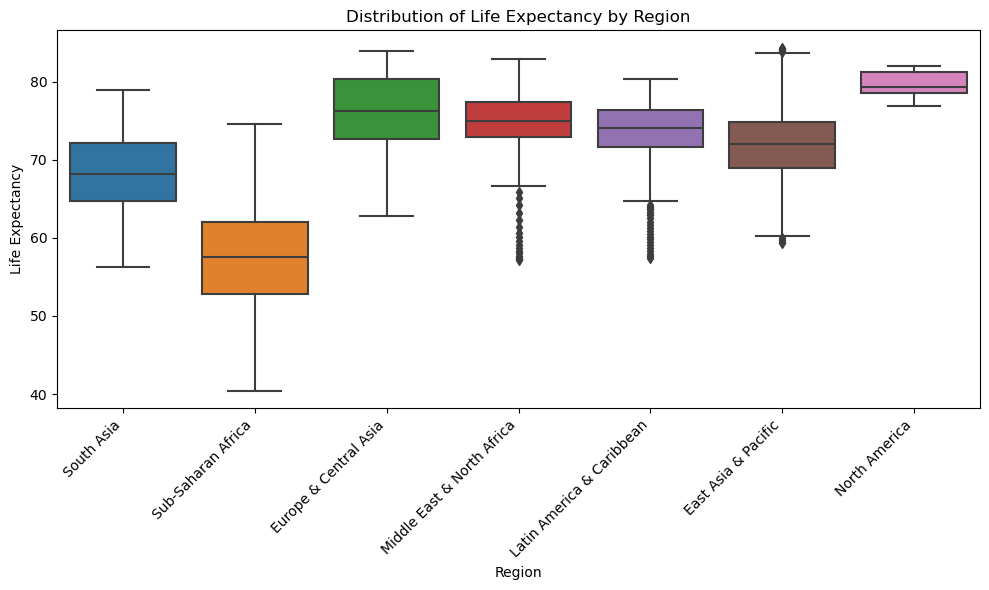

In [29]:
# Set plot size
plt.figure(figsize=(10, 6))

# Plot distribution of life expectancy by region
sns.boxplot(x='Region', y='Life_expectancy', data=data)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set plot title and labels
plt.title('Distribution of Life Expectancy by Region')
plt.xlabel('Region')
plt.ylabel('Life Expectancy')

# Display the plot
plt.tight_layout()
plt.show()

### Interpretation

Sub-Saharan Africa has the lowest median life expectancy with the widest range, showing significant variability across the region. North America has the highest and most consistent life expectancy, with the narrowest distribution. Europe & Central Asia and Latin America & the Caribbean both have relatively high medians, with Europe showing a tighter range than Latin America. South Asia and East Asia & Pacific have similar mid-range life expectancies, with slightly broader distributions. Overall, life expectancy varies considerably by region, with notable differences in both the median and the spread of values.

In [30]:
# Grouping the data by Region and Country and calculating the mean life expectancy for each
average_life_expectancy = data.groupby(['Region', 'Country Name'])['Life_expectancy'].mean().reset_index()

# For each region, find the country with the highest and lowest life expectancy
highest_life_expectancy = average_life_expectancy.loc[average_life_expectancy.groupby('Region')['Life_expectancy'].idxmax()]
lowest_life_expectancy = average_life_expectancy.loc[average_life_expectancy.groupby('Region')['Life_expectancy'].idxmin()]

# Merging the two results into one DataFrame for clarity
result = pd.merge(highest_life_expectancy, lowest_life_expectancy, on='Region', suffixes=('_Highest', '_Lowest'))
result

,Region,Country Name_Highest,Life_expectancy_Highest,Country Name_Lowest,Life_expectancy_Lowest
0,East Asia & Pacific,Japan,82.891553,Papua New Guinea,62.006632
1,Europe & Central Asia,Switzerland,82.212580,Turkmenistan,66.363789
2,Latin America & Caribbean,Costa Rica,78.843579,Haiti,60.579737
3,Middle East & North Africa,Israel,81.263671,Djibouti,61.026316
4,North America,Canada,80.996021,United States,78.136457
5,South Asia,Maldives,75.571842,Afghanistan,60.829211
6,Sub-Saharan Africa,Mauritius,73.222465,Lesotho,47.106158


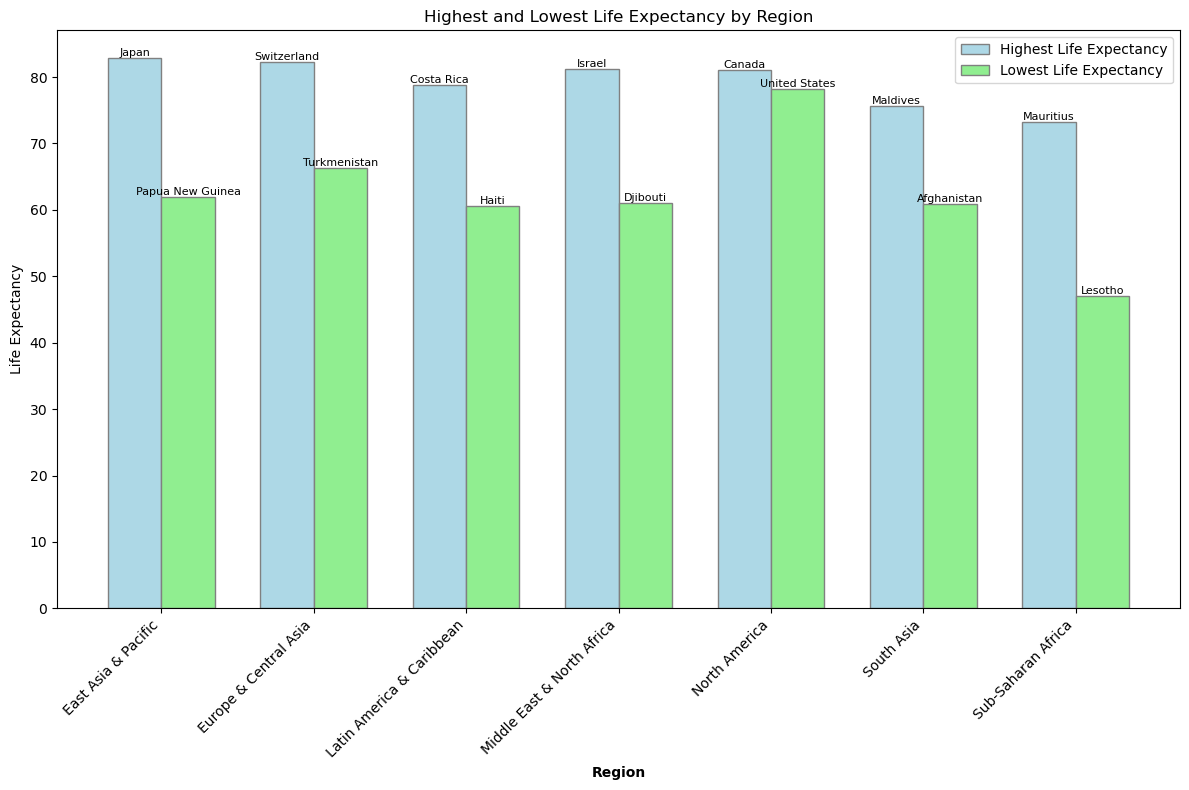

In [31]:
# Creating a better visualization with side-by-side bars and adding the country names for each bar

plt.figure(figsize=(12, 8))

# Creating a bar width variable for side-by-side bars
bar_width = 0.35
regions = result['Region']

# Positions for the bars
r1 = np.arange(len(regions))
r2 = [x + bar_width for x in r1]

# Plotting the highest life expectancy
bars1 = plt.bar(r1, result['Life_expectancy_Highest'], color='lightblue', width=bar_width, edgecolor='grey', label='Highest Life Expectancy')

# Plotting the lowest life expectancy
bars2 = plt.bar(r2, result['Life_expectancy_Lowest'], color='lightgreen', width=bar_width, edgecolor='grey', label='Lowest Life Expectancy')

# Adding labels and title
plt.xlabel('Region', fontweight='bold')
plt.ylabel('Life Expectancy')
plt.title('Highest and Lowest Life Expectancy by Region')

# Adding xticks to the middle of the bars
plt.xticks([r + bar_width / 2 for r in range(len(regions))], regions, rotation=45, ha='right')

# Adding country names on top of the bars
for bar, country in zip(bars1, result['Country Name_Highest']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, country, ha='center', va='bottom', fontsize=8)

for bar, country in zip(bars2, result['Country Name_Lowest']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, country, ha='center', va='bottom', fontsize=8)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


The largest life expectancy gap is in Sub-Saharan Africa (26.11 years between Mauritius and Lesotho).
The smallest gap is in North America (2.86 years between Canada and the United States).
Other regions, such as East Asia & Pacific, Middle East & North Africa, and Latin America & Caribbean, show gaps of around 18 to 20 years between the highest and lowest countries.
This highlights the significant disparities in life expectancy within each region, with some countries experiencing much lower life expectancies compared to the highest performers in their regions.

### Life expectancy trend over years

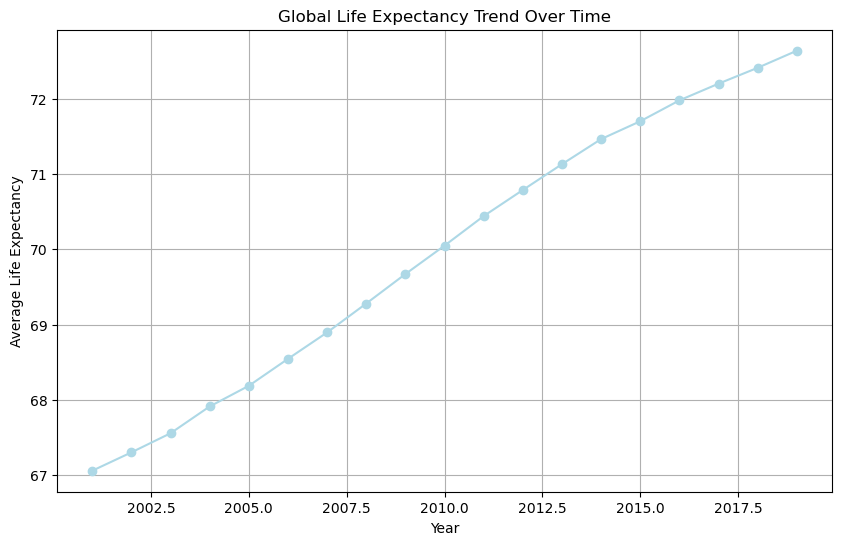

In [32]:
#general trend 
global_life_expectancy = data.groupby('Year')['Life_expectancy'].mean()

# Plot global trend
plt.figure(figsize=(10, 6))
plt.plot(global_life_expectancy.index, global_life_expectancy.values, marker='o', linestyle='-', color='lightblue')
plt.title('Global Life Expectancy Trend Over Time')
plt.xlabel('Year')
plt.ylabel('Average Life Expectancy')
plt.grid(True)
plt.show()

##### There is a consistent increase in life expectancy over time across all the regions. There may be explained by the improvement in healthcare, technology and many other factors.

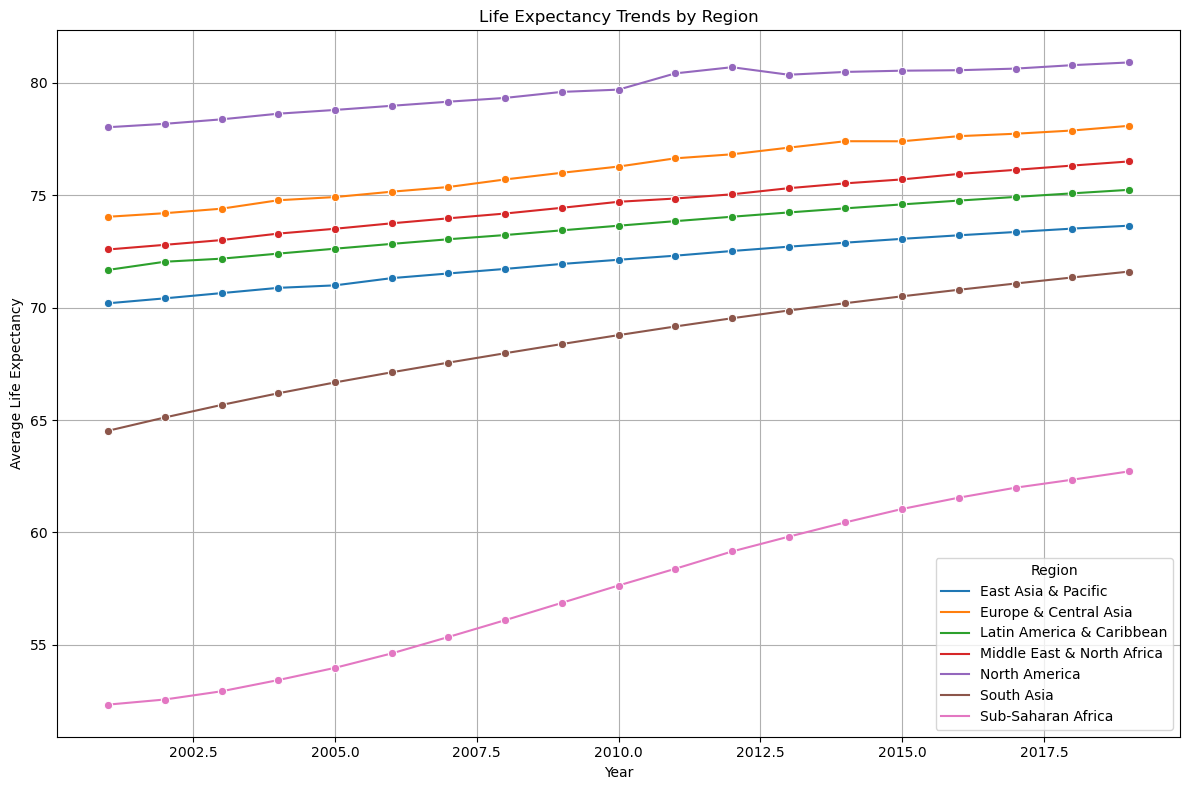

In [33]:
# Grouping data by Region and Year to calculate the mean life expectancy per region over time
region_life_expectancy = data.groupby(['Region', 'Year'])['Life_expectancy'].mean().reset_index()

# Create a line plot using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x='Year', y='Life_expectancy', hue='Region', data=region_life_expectancy, marker='o')

# Adding title and labels
plt.title('Life Expectancy Trends by Region')
plt.xlabel('Year')
plt.ylabel('Average Life Expectancy')

# Adjusting layout
plt.grid(True)
plt.tight_layout()
plt.show()

##### As we have plotted the regions individually, we still still the same trend in life expectancy. It is increaing. However, we have noticed a peak in North America between year 2010 and 2012, but a sudden decrease mid-half of year 2012. Let's take a close look at North America. 

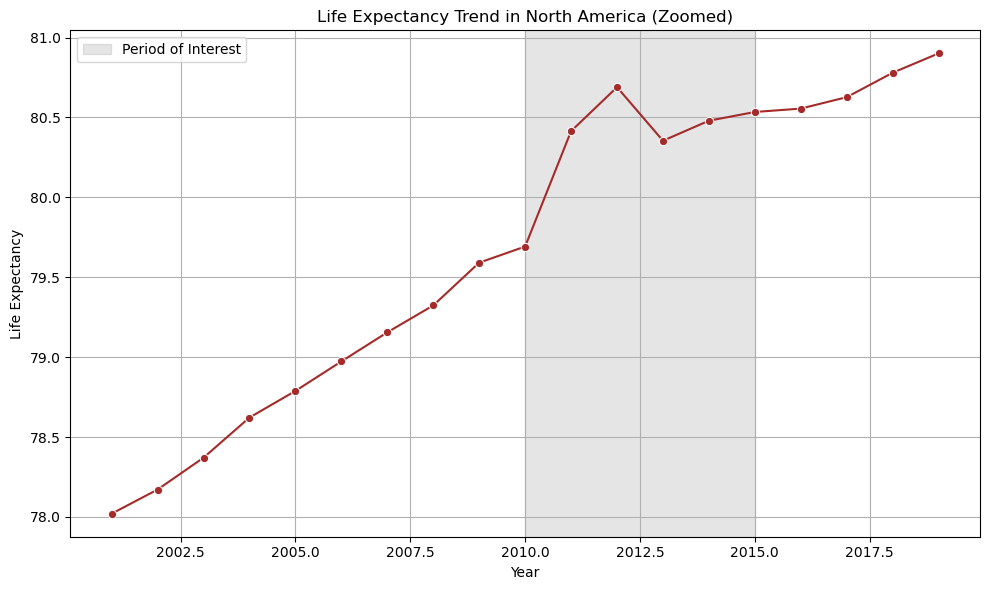

           Region  Year  Life_expectancy
76  North America  2001        78.020325
77  North America  2002        78.171545
78  North America  2003        78.370732
79  North America  2004        78.621951
80  North America  2005        78.788618
81  North America  2006        78.973171
82  North America  2007        79.155285
83  North America  2008        79.323577
84  North America  2009        79.591268
85  North America  2010        79.692114
86  North America  2011        80.414309
87  North America  2012        80.689350
88  North America  2013        80.354228
89  North America  2014        80.479593
90  North America  2015        80.534146
91  North America  2016        80.555366
92  North America  2017        80.626992
93  North America  2018        80.779837
94  North America  2019        80.901057


In [34]:
# Filter data for North America
north_america_data = region_life_expectancy[region_life_expectancy['Region'] == 'North America']

# Plot the life expectancy trend for North America
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Life_expectancy', data=north_america_data, marker='o', color='brown')

# Adding title and labels
plt.title('Life Expectancy Trend in North America (Zoomed)')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')

# Highlight the period from 2010 to 2015
plt.axvspan(2010, 2015, color='grey', alpha=0.2, label='Period of Interest')

# Show the plot
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the exact values to see the peak and post-2012 drop
print(north_america_data)

We can now observe that there was a decline in life expectancy between 2013 and 2014, which raises important questions regarding the underlying causes. While it could potentially be an insignificant fluctuation, it is worth investigating whether specific factors, such as healthcare policy changes, disease outbreaks, or socioeconomic shifts, played a role. Either way, this anomaly presents an interesting area for further exploration, offering potential insights into the broader determinants of life expectancy during this period. Understanding this decline may help us assess if it was an isolated event or part of a larger trend

## Factors influencing life expectancy

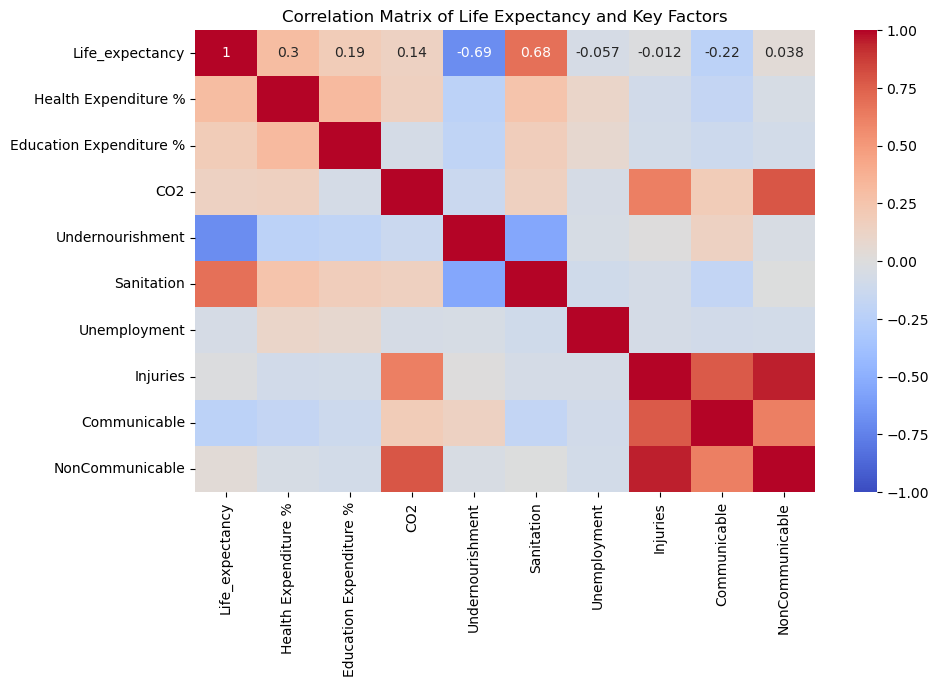

In [35]:
# Correlation matrix of life expectancy and key factors
key_factors = ['Life_expectancy', 'Health Expenditure %', 'Education Expenditure %', 'CO2', 
               'Undernourishment', 'Sanitation', 'Unemployment', 'Injuries','Communicable',	'NonCommunicable']

# Calculate the correlation matrix
correlation_matrix = data[key_factors].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Life Expectancy and Key Factors')
plt.show()

### Interpretation

**Health Expenditure %**: Moderately positive correlation (0.30), suggesting that higher health expenditure is associated with a longer life expectancy.

**Education Expenditure %**: Positive correlation (0.19), indicating that higher education investment slightly correlates with better life expectancy.

**CO2 Emissions**: Negative correlation (-0.69), suggesting that higher CO2 emissions might be linked to shorter life expectancy, possibly due to environmental health impacts.

**Undernourishment**: Strong negative correlation (-0.69), indicating a significant impact on reducing life expectancy.

**Sanitation**: Positive correlation (0.68), which shows a strong association between access to sanitation and higher life expectancy.

**Unemployment, Injuries, and Communicable Diseases**: These show weak to moderate negative correlations with life expectancy, with communicable diseases having a higher negative impact.

**Non-Communicable Diseases**: A minor positive correlation (0.038) suggests a very weak link.

In [36]:
# linear regression

# Define the independent variables (key factors)
X = data[['Health Expenditure %', 'Education Expenditure %', 'CO2', 
               'Undernourishment', 'Sanitation', 'Unemployment', 'Injuries','Communicable',	'NonCommunicable']]

# Define the dependent variable (life expectancy)
y = data['Life_expectancy']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Life_expectancy   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     685.3
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        17:51:25   Log-Likelihood:                -10279.
No. Observations:                3306   AIC:                         2.058e+04
Df Residuals:                    3296   BIC:                         2.064e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Interpretation 

This is an OLS (Ordinary Least Squares) regression, where life expectancy is modeled as the dependent variable and various factors are the independent variables.

**R-squared = 0.652**: This suggests that 65.2% of the variance in life expectancy is explained by the factors included in the model, indicating a fairly good fit.

**Health Expenditure %**: Has a positive coefficient (0.3480) and is statistically significant (p < 0.001), suggesting it has a significant positive impact on life expectancy.

**CO2 emission**: Negative coefficient (-1.23e-06) and statistically significant (p < 0.001), reinforcing the negative impact of CO2 on life expectancy.

**Undernourishment**: Strong negative impact (-0.3744) and statistically significant, aligning with the feature importance and correlation results.

**Sanitation**: Positive coefficient (0.1309) and highly significant, further confirming its crucial role in life expectancy.

**Unemployment and Communicable Diseases**: Both have negative coefficients and are statistically significant, showing their detrimental effects on life expectancy.


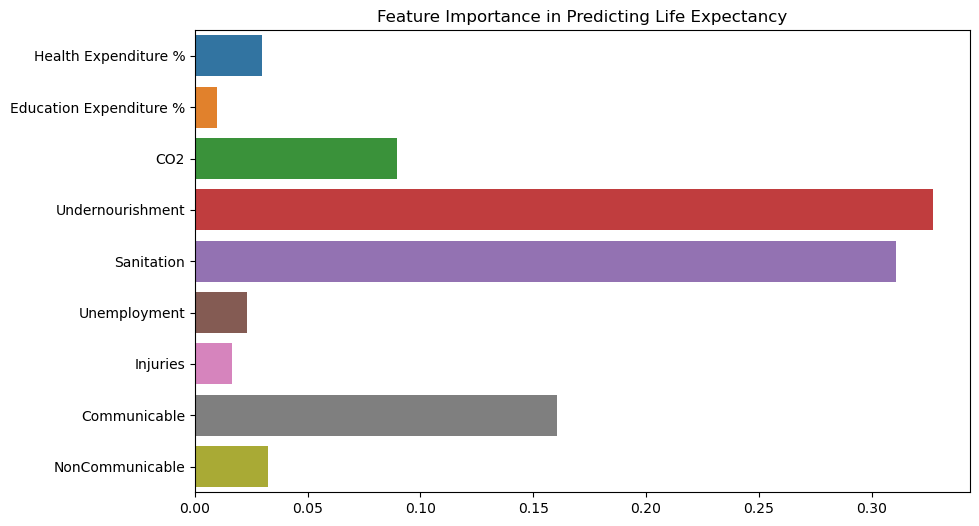

In [37]:
#feature importance 
# Prepare data for modeling
X = data[['Health Expenditure %', 'Education Expenditure %', 'CO2', 
               'Undernourishment', 'Sanitation', 'Unemployment', 'Injuries','Communicable',	'NonCommunicable']]
 
y = data['Life_expectancy']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importance = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=X.columns)
plt.title('Feature Importance in Predicting Life Expectancy')
plt.show()

### Interpretation 

**Undernourishment**: The most important predictor, which aligns with the strong negative correlation observed.
    
**Sanitation**: The second most important factor, reinforcing the idea that access to proper sanitation is crucial for life expectancy.
    
**CO2 Emission**: Plays a significant role, possibly due to the long-term health effects of pollution.

**Communicable Diseases**: Also important, highlighting the ongoing public health concern posed by these diseases.

**Health Expenditure %**: Though not the most critical factor, it still shows significance in predicting life expectancy.

# Conclusion 
The three methods we used to analyze the influence of various factors on life expectancy consistently highlight the following:

**Undernourishment and Sanitation** are the two most critical factors influencing life expectancy. Addressing undernourishment and improving sanitation can significantly increase life expectancy.
**CO2 emissions** have a notable negative impact, showing that environmental factors also play a key role in life expectancy.
**Health Expenditure and Communicable Diseases** are important, with higher health spending contributing positively and communicable diseases negatively affecting life expectancy.
Addressing environmental concerns, improving public health infrastructure, and reducing undernourishment should be key focus areas for improving life expectancy in populations